In [1]:
import matplotlib.pyplot as plt
from pyvis.network import Network
import networkx as nx
from pathlib import Path
import pandas as pd
import numpy as np

import nest_asyncio

from llama_index.core import Response
from llama_index.core.evaluation import (
    FaithfulnessEvaluator,
    DatasetGenerator,
    RelevancyEvaluator,
)

from app.notebooks.helpers.bot.kg_generation import create_kg_triplets
from notebooks.helpers.bot.bot import (
    get_chat_engine,
    load_llm,
    load_embedding_model,
    setup_index_and_storage,
    generate_pairings_documents,
    service,
)

nest_asyncio.apply()
%matplotlib inline

In [2]:
def display_eval_df(query: str, response: Response, eval_result: Response) -> None:
    eval_df = pd.DataFrame(
        {
            "Query": query,
            "Response": str(response),
            "Source": (' '.join(eval_result.contexts)[:1000] + "..."),
            "Evaluation Result": eval_result.passing,
        },
        index = [0]
    )
    eval_df = eval_df.style.set_properties(
        **{
            "inline-size": "600px",
            "overflow-wrap": "break-word",
        },
        subset=["Response", "Source"]
    )
    display(eval_df)



In [3]:
KG = create_kg_triplets(sample_size=500)
kg_pairings = KG.apply(generate_pairings_documents, axis=1)

In [4]:
print(kg_pairings.iloc[0].get_content(metadata_mode='llm'))
print(kg_pairings.iloc[0].get_node_info())

Metadata: category=>White::variety_location=>Riesling Niederosterreich, Austria::price=>$23::variety=>Riesling::vintage=>2001::winery=>Salomon-Undhof::country=>Austria::province=>Kremstal
-----
Content: The object wine, **Riesling** has a relationship of **from_category** with the object **White
The object wine, **Riesling** has a relationship of **variety_location** with the object **Riesling Niederosterreich, Austria
The object wine, **Salomon-Undhof 2001 Kremser Koegl Riesling Riesling (Kremstal)** has a relationship of **has_category** with the object **White
The object wine, **Salomon-Undhof 2001 Kremser Koegl Riesling Riesling (Kremstal)** has a relationship of **has_price** with the object **$23
The object wine, **Salomon-Undhof 2001 Kremser Koegl Riesling Riesling (Kremstal)** has a relationship of **has_variety** with the object **Riesling
The object wine, **Salomon-Undhof 2001 Kremser Koegl Riesling Riesling (Kremstal)** has a relationship of **vintage_year** with the object 

In [5]:
llm = load_llm('ollama')

In [6]:
embed_model = load_embedding_model("foodbert")
service_context = service(llm=llm, embed_model=embed_model)

In [7]:
storage_context, kg_index = setup_index_and_storage(
        service=service_context,
        kg_pairings=kg_pairings,
        show_progress=False,
        force=True,
    )

In [8]:
chat_engine = get_chat_engine(
    kg_index,
    chat_mode="context",
    retriver_mode="hybrid",
    use_global_node_triplets=True,
    max_keywords_per_query=10,
    num_chunks_per_query=15,
    similarity_top_k=2,
    graph_store_query_depth=2,
)
chat_engine.reset()

In [ ]:
data_generator = DatasetGenerator.from_documents(
        kg_pairings, service_context=service_context
)
eval_questions = data_generator.generate_questions_from_nodes(num=3)

evaluator = RelevancyEvaluator(service_context=service_context)

In [ ]:
eval_questions[1]

In [ ]:
response = chat_engine.chat(eval_questions[1])
print(response)
eval_result = evaluator.evaluate_response(
    query=eval_questions[1], response=response
)

In [ ]:
print(eval_result.passing)
print(eval_result.score)
print(eval_result.feedback)
print(eval_result.contexts)

In [ ]:
display_eval_df(eval_questions[1], response, eval_result)

In [9]:
response = chat_engine.chat(
    "What are the primary grape varieties used in producing Bordeaux wines?",
)

print(response)

INFO:httpx:HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
Extracted keywords: ['primary', 'keywords', '10', 'I\'d be happy to help! Here are the 10 keywords that can help us find answers to the question "What are the primary grape varieties used in producing Bordeaux wines?":\n\nKEYWORDS: Bordeaux', 'Bordeaux', 'used', 'grapes', 'happy', 'I', 'wines', 'us', 'answers', 'help', 'wine', 'find', 'KEYWORDS', 'grape', 'What', 'question', 'producing', 'Sure', 'France.', 'varieties', 'grape varieties', 'Here']
INFO:httpx:HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
HTTP Request: POST http

In [13]:
G = kg_index.get_networkx_graph(limit=500)

In [14]:
net = Network(notebook = True, cdn_resources = "remote",
                bgcolor = "#222222",
                font_color = "white",
                height = "750px",
                width = "100%",
                select_menu = True,
                filter_menu = True,
)
net.show_buttons(filter_="physics")
net.from_nx(G)
net.show("nx.html")

nx.html


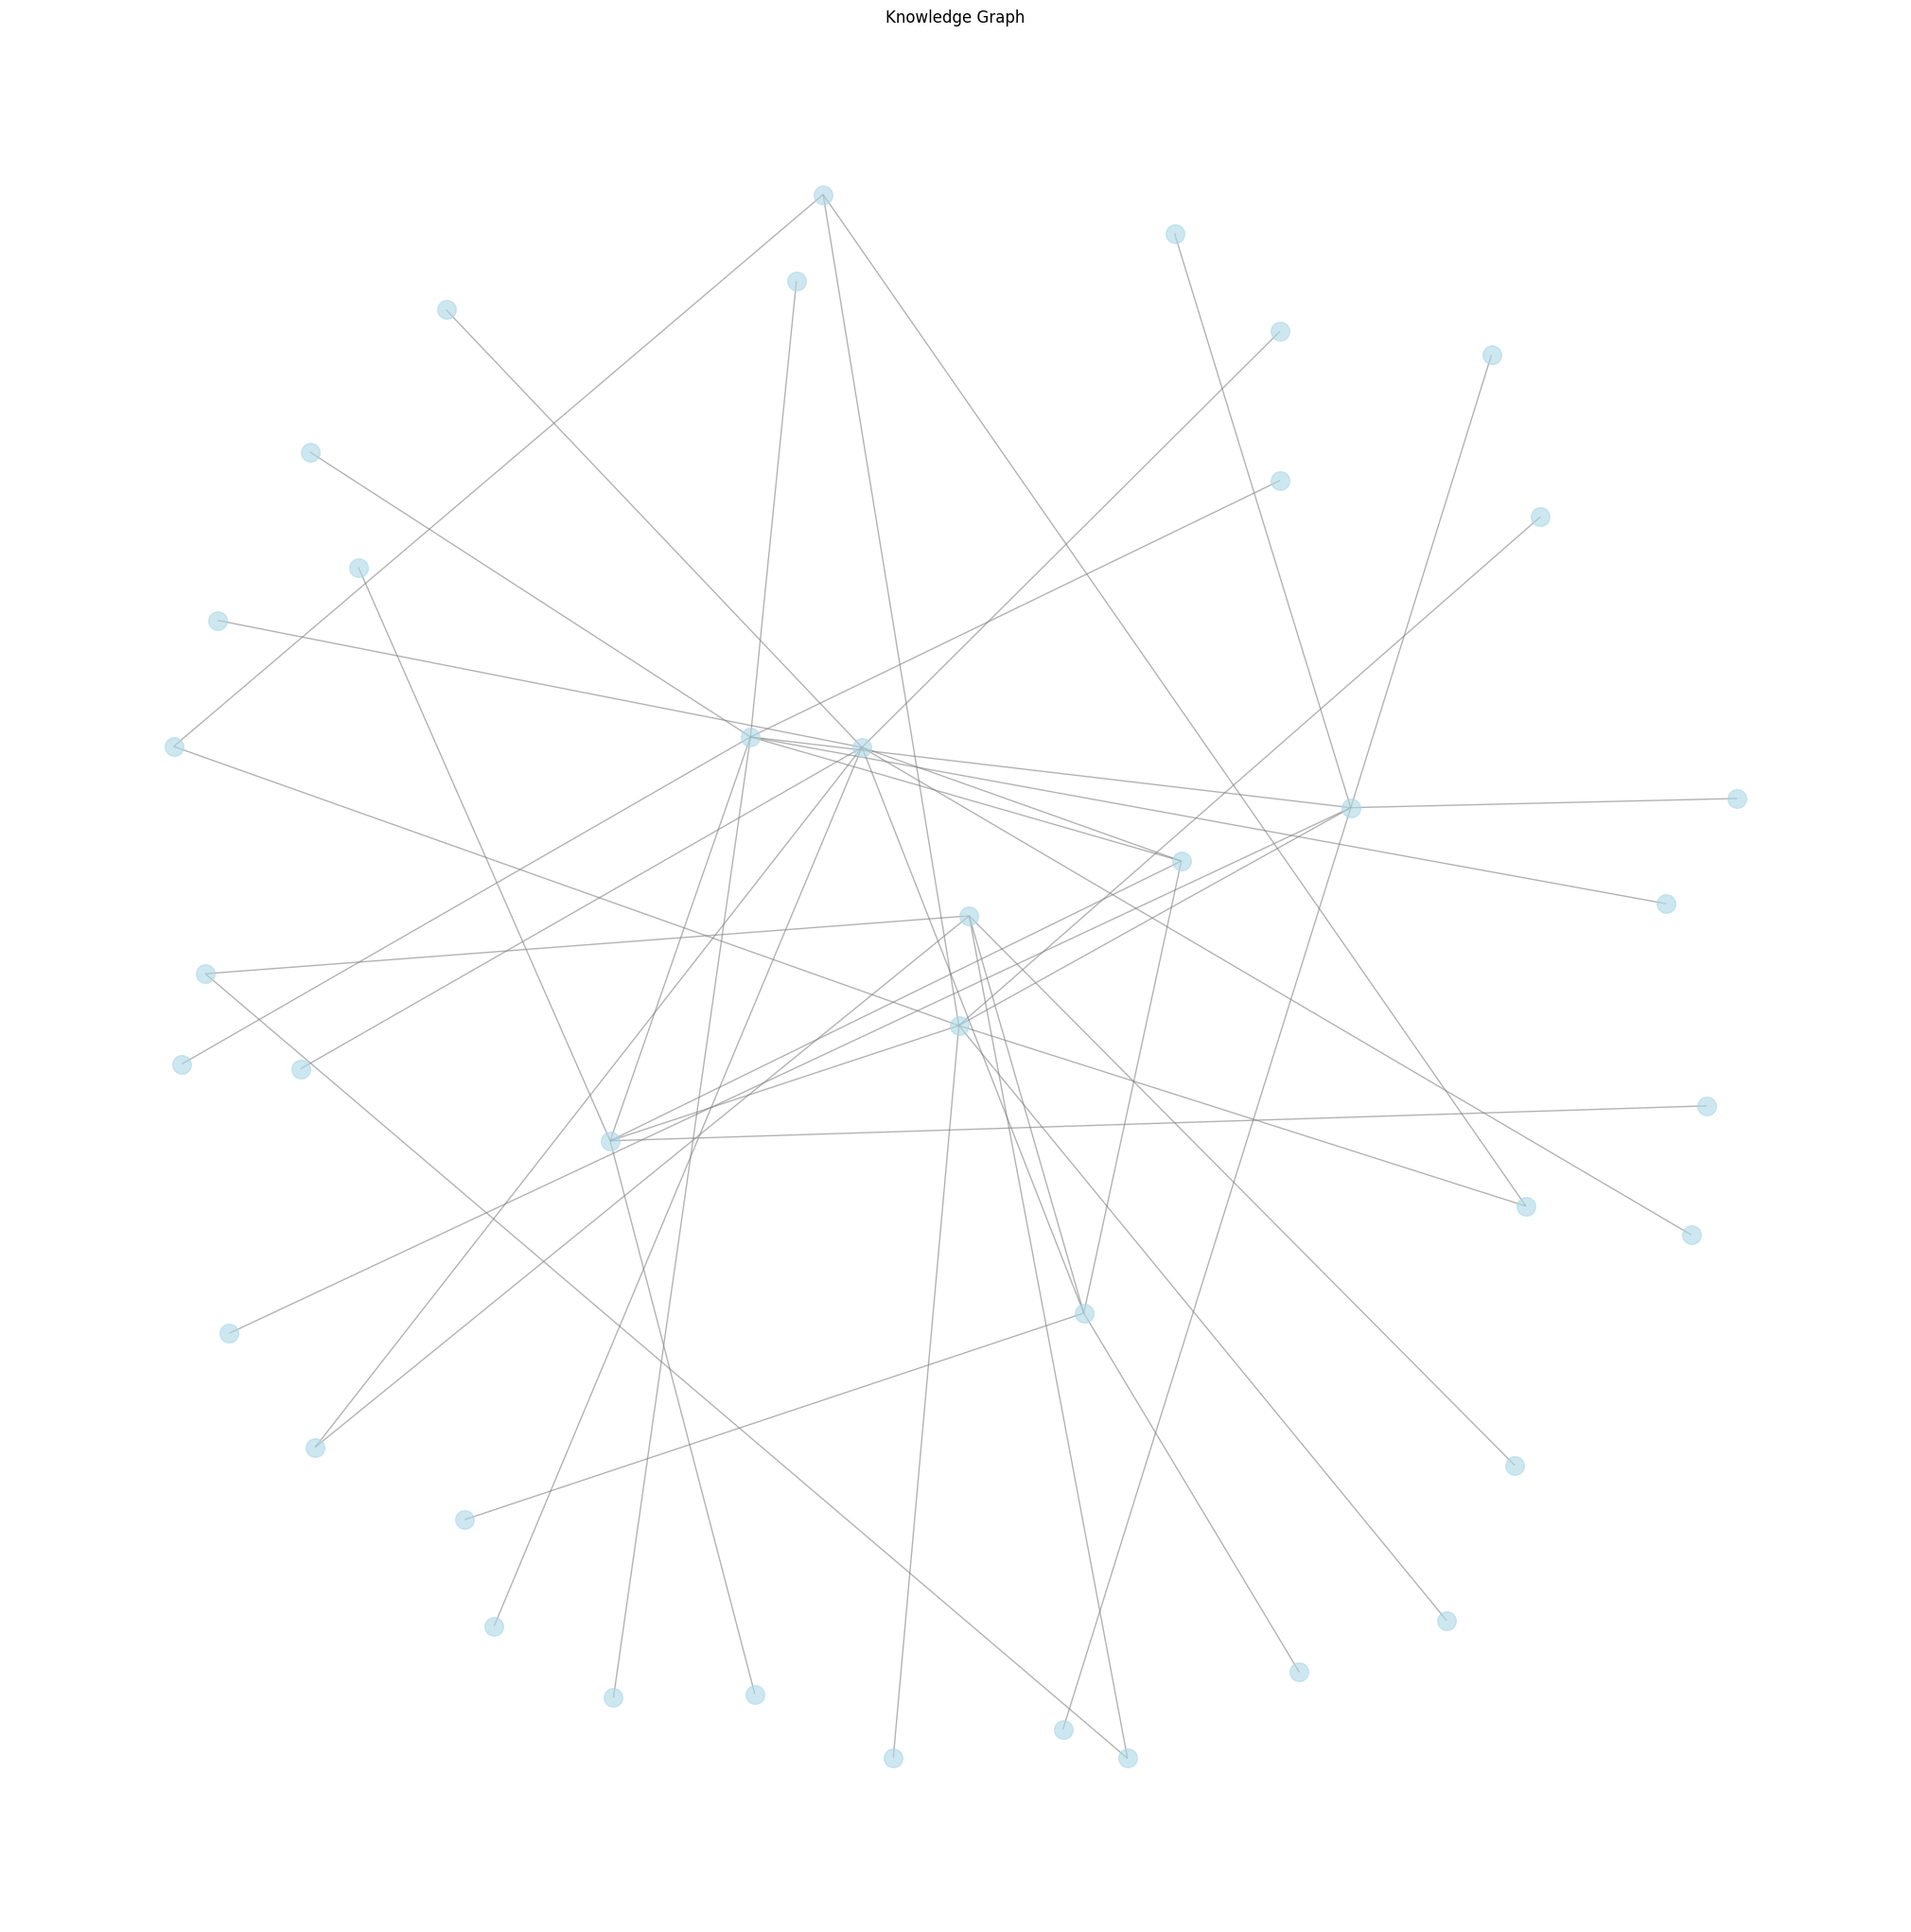

In [15]:
pos = nx.spring_layout(G, seed=42, k=1.5)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(20, 20))
nx.draw(G, pos, font_size=8, node_size=200, node_color='lightblue', edge_color='gray', alpha=0.6)
# nx.draw_networkx_edge_labels(G, pos, font_size=3, label_pos=0.3, verticalalignment='baseline')
plt.title('Knowledge Graph')
plt.show()

In [16]:
for edge in G.edges(data=True):
    print(edge)

('Riesling', 'White', {'label': 'from_category', 'title': 'from_category', 'width': 1})
('Riesling', 'Riesling Niederosterreich, Austria', {'label': 'variety_location', 'title': 'variety_location', 'width': 1})
('Riesling', 'Riesling Finger Lakes, New York, USA', {'label': 'variety_location', 'title': 'variety_location', 'width': 1})
('Riesling', 'Riesling South Australia, Australia', {'label': 'variety_location', 'title': 'variety_location', 'width': 1})
('Riesling', 'Riesling Mosel, Germany', {'label': 'variety_location', 'title': 'variety_location', 'width': 1})
('Riesling', 'Riesling Canterbury and Waipara, New Zealand', {'label': 'variety_location', 'title': 'variety_location', 'width': 1})
('Riesling', 'Riesling Ontario, Canada', {'label': 'variety_location', 'title': 'variety_location', 'width': 1})
('Riesling', 'Riesling Alsace, France', {'label': 'variety_location', 'title': 'variety_location', 'width': 1})
('Riesling', 'Salomon-Undhof 2001 Kremser Koegl Riesling Riesling (Kre